In [ ]:
%pip install pycld3
%pip install pymorphy2
%pip install -U pymorphy2-dicts-ru
%pip install -U pymorphy2-dicts-uk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.6 MB 4.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.3 MB/s 
     |████████████████████████████████| 8.2 MB 12.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.0 MB 5.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import cld3
import pymorphy2
import re
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
keywords_ukr = ['війна', 'військовий', 'військовослужбовець', 'боєць', 'бригада',
                'окупант', 'окупанти', 'зсу', 'збройні сили україни',
                'втрати', 'втрата', 'санкція', 'санкції', 'ппо', 'пво', 'танк',
                'град', 'байрактар', 'хімарс', 'град', 'ураган', 'бпла', 'стугна',
                'вторгнення', 'окупація', 'біженці', 'біженець', 'переселенець',
                'переселенці', 'азов', 'азовсталь', 'обстріл', 'тривога',
                'тероборона', 'тро', 'лнр', 'днр', 'ракетний', 'крейсер',
                'міна', 'ракета', 'атака', 'міг', 'міг-', 'озброєння',
                'ворог', 'озброїти', 'зміїний', 'безпілотник', 'безпілотники',
                'полонений', 'полонені', 'полон', 'переговори', 'рєзніков', 'орк',
                'орки', 'вибух', 'зброя', 'росія', 'рф', 'окупований',
                'боєприпаси', 'боєприпас']

keywords_rus = ['война', 'лнр', 'днр', 'вторжение', 'спецоперация', 'азов',
                'оккупант', 'оккупанты', 'оккупация', 'потери', 'потеря',
                'бои', 'воин', 'враг', 'ракетный', 'крейсер', 'ракета', 'атака',
                'всу', 'бригада', 'пво', 'миг', 'миг-', 'вооружение',
                'враг', 'вооружить', 'прилёт', 'битва', 'змеиный', 'санкции',
                'санкция', 'беспилотник', 'беспилотники', 'пленный', 'пленные',
                'плен', 'мид', 'переговоры', 'тревога', 'резников', 'захват',
                'орк', 'орки', 'оружие', 'оккупированный']

In [ ]:
df = pd.read_csv('posts/labels_b.tsv', delimiter='\t')
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,message,title,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,label,Unnamed: 11
0,NaN,NaN,NaN,1,"Снабжение россиян подорвано на порядок, - Злой...","Снабжение россиян подорвано на порядок, - Злой...",NaN,NaN,NaN,NaN,w,NaN
1,NaN,NaN,NaN,2,На востоке продолжаются бои за Северодонецк. У...,Ситуация на востоке: ВСУ заставили врага отсту...,NaN,NaN,NaN,NaN,w,NaN
2,NaN,NaN,NaN,3,"#война Поговорили с Игорем Поповым о том, не с...",Автор песни One Ukrainian man Игорь Попов: Мне...,NaN,NaN,NaN,NaN,w,NaN
3,NaN,NaN,NaN,4,Что ты такое?😯,NaN,NaN,NaN,NaN,NaN,n,NaN
4,NaN,NaN,NaN,5,"По накалу страстей на главных кортах Лондона, ...",Как казахстанские теннисисты провели второй иг...,NaN,NaN,NaN,NaN,n,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
295,NaN,NaN,NaN,296,Как жестоки могут быть люди….,"Модель раскритиковали за фото после родов, и о...",NaN,NaN,NaN,NaN,n,NaN
296,NaN,NaN,NaN,297,"Зарубежные бренды одежды — H&M, Mango и группа...",Зарубежные бренды одежды распродают остатки с ...,NaN,NaN,NaN,NaN,n,NaN
297,NaN,NaN,NaN,298,"Однолюбы. Кто они? Я расскажу тебе, хочешь? Ав...",NaN,NaN,NaN,NaN,NaN,n,NaN
298,NaN,NaN,NaN,299,Всемирная организация здравоохранения подтверд...,ВОЗ: оспу обезьян обнаружили у 92 человек из 1...,NaN,NaN,NaN,NaN,n,NaN


In [ ]:
def set_label_cld3(message: str) -> str:
  try:
    label = cld3.get_language(message)
    if label[0] == 'uk':
      return 'u'
    elif label[0] == 'ru':
      return 'r'
    else:
      return 'xx'
  except:
    return 'xx'

In [ ]:
# drop unnamed columns
# and add language label
for column in df.columns:
  if column.startswith('Unnamed'):
    df.drop([column], axis=1, inplace=True)

df['text'] = df['message'].astype(str) + ' ' + df['title'].astype(str)
df['language'] =  np.vectorize(set_label_cld3)(df['message'])
df.drop(['message', 'title'], axis=1, inplace=True)
df = df.reindex(columns=['text', 'label', 'language'])
df

,text,label,language
0,"Снабжение россиян подорвано на порядок, - Злой...",w,r
1,На востоке продолжаются бои за Северодонецк. У...,w,r
2,"#война Поговорили с Игорем Поповым о том, не с...",w,r
3,Что ты такое?😯 nan,n,r
4,"По накалу страстей на главных кортах Лондона, ...",n,r
...,...,...,...
295,Как жестоки могут быть люди…. Модель раскритик...,n,r
296,"Зарубежные бренды одежды — H&M, Mango и группа...",n,r
297,"Однолюбы. Кто они? Я расскажу тебе, хочешь? Ав...",n,r
298,Всемирная организация здравоохранения подтверд...,n,r


In [ ]:
def preprocess(text: str, lang: str) -> list:
  if lang == 'u':
    text = re.sub('[^а-яґієї\'\-]+', ' ', text.lower())
    morph = pymorphy2.MorphAnalyzer(lang='uk')
  else:
    text = re.sub('[^а-яё\'\-]+', ' ', text.lower())
    morph = pymorphy2.MorphAnalyzer()
  words = list(map(lambda x: morph.parse(x)[0].normal_form, [x for x in text.split() if x]))
  return ' '.join(words).strip()

In [ ]:
df['words'] =  np.vectorize(preprocess)(df['text'], df['language'])
df = df.reindex(columns=['text', 'words', 'language', 'label'])

df[df['language'] == 'u']

,text,words,language,label
100,"Українське сонце Ми - той народ, що творить св...",український сонце ми - той народ що творити св...,u,w
101,"Друга армія світу професійно ""демілітаризує"" У...",другий армія світ професійно демілітаризувати ...,u,w
102,Росія ймовірно планує здійснити атаку під фаль...,росія ймовірно планувати здійснити атака під ф...,u,w
103,"БРОВАРИ, повітряна тривога! nan",бровари повітряний тривога,u,w
104,"Білик розповіла, що чоловік Повалій – Ліхута п...",білик розповісти що чоловік повалій ліхута під...,u,n
...,...,...,...,...
195,Дуже смачне листкове тісто всього за 10 хвилин...,дуже смачний листковий тісто весь за хвилина т...,u,n
196,"Розповідаємо, які православні свята відзначают...",розповідати який православний свято відзначати...,u,n
197,"Секретар генради путінської партії ""Єдиної Рос...",секретар генрад путінський партія єдиний росія...,u,w
198,Захопили! Страшна звістка з Сєвєродонецька – З...,захопити страшний звістка з сєвєродонецьк зсу ...,u,w


In [ ]:
def war_label(words: str, lang: str) -> str:
  words = words.split()
  if lang == 'u':
    for word in keywords_ukr:
      if word in words:
        return 'w'
    return 'n'
  else:
    for word in keywords_rus:
      if word in words:
        return 'w'
    return 'n'

In [ ]:
df['pred_label'] =  np.vectorize(war_label)(df['words'], df['language'])
df

,text,words,language,label,pred_label
0,"Снабжение россиян подорвано на порядок, - Злой...",снабжение россиянин подорвать на порядок - зло...,r,w,w
1,На востоке продолжаются бои за Северодонецк. У...,на восток продолжаться бой за северодонецк укр...,r,w,w
2,"#война Поговорили с Игорем Поповым о том, не с...",война поговорить с игорь попов о тот не страшн...,r,w,w
3,Что ты такое?😯 nan,что ты такой,r,n,n
4,"По накалу страстей на главных кортах Лондона, ...",по накал страсть на главный корт лондон вторни...,r,n,n
...,...,...,...,...,...
295,Как жестоки могут быть люди…. Модель раскритик...,как жестокий мочь быть человек модель раскрити...,r,n,n
296,"Зарубежные бренды одежды — H&M, Mango и группа...",зарубежный бренд одежда и группа компания расп...,r,n,w
297,"Однолюбы. Кто они? Я расскажу тебе, хочешь? Ав...",однолюб кто они я рассказать ты хотеть автор д...,r,n,n
298,Всемирная организация здравоохранения подтверд...,всемирный организация здравоохранение подтверд...,r,n,n


In [ ]:
df['res'] = np.where(df['label'] == df['pred_label'], 1, 0)
print(df['res'].sum())
df

245


,text,words,language,label,pred_label,res
0,"Снабжение россиян подорвано на порядок, - Злой...",снабжение россиянин подорвать на порядок - зло...,r,w,w,1
1,На востоке продолжаются бои за Северодонецк. У...,на восток продолжаться бой за северодонецк укр...,r,w,w,1
2,"#война Поговорили с Игорем Поповым о том, не с...",война поговорить с игорь попов о тот не страшн...,r,w,w,1
3,Что ты такое?😯 nan,что ты такой,r,n,n,1
4,"По накалу страстей на главных кортах Лондона, ...",по накал страсть на главный корт лондон вторни...,r,n,n,1
...,...,...,...,...,...,...
295,Как жестоки могут быть люди…. Модель раскритик...,как жестокий мочь быть человек модель раскрити...,r,n,n,1
296,"Зарубежные бренды одежды — H&M, Mango и группа...",зарубежный бренд одежда и группа компания расп...,r,n,w,0
297,"Однолюбы. Кто они? Я расскажу тебе, хочешь? Ав...",однолюб кто они я рассказать ты хотеть автор д...,r,n,n,1
298,Всемирная организация здравоохранения подтверд...,всемирный организация здравоохранение подтверд...,r,n,n,1


In [ ]:
df_ukr = df[df['language'] == 'u']
df_rus = df[df['language'] == 'r']

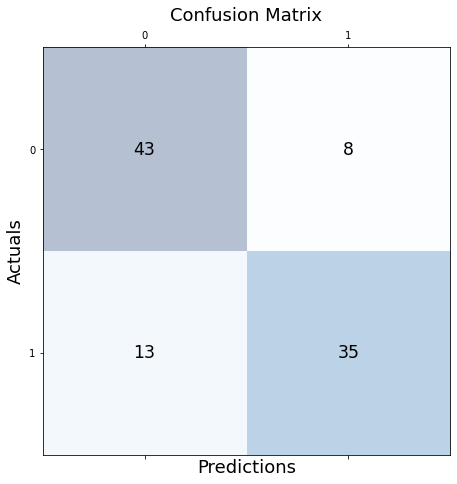

In [ ]:
conf_matrix = confusion_matrix(y_true=df_ukr['label'], y_pred=df_ukr['pred_label'], labels=labels)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

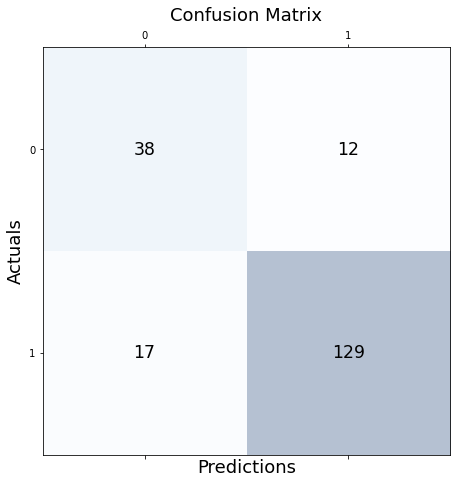

In [ ]:
conf_matrix = confusion_matrix(y_true=df_rus['label'], y_pred=df_rus['pred_label'], labels=labels)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()